this will train a model on NON ISOTOPE containing data sets. It uses the GPR kernel. your variable to change is the kernel, it's a digit. your outcome is a .pkl. that is your trained model

In [1]:


%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
#from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ConstantKernel, WhiteKernel


#from umda.data import load_data, load_pipeline
#for import load_data and load_pipeline
import pandas as pd
import h5py
from joblib import load
from pathlib import Path


#from umda.training import get_bootstrap_samples, compose_model
#for replacing umda.training

from typing import Tuple
from math import floor
import tqdm

import numpy as np
from scipy.stats import lognorm, uniform
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import kernels
from sklearn.utils import resample

# these imports are specifically for writing the custom CV
from sklearn.model_selection._split import BaseCrossValidator
from sklearn.utils.validation import _num_samples


#associated with VICGAE
from typing import Tuple, Dict
import warnings

from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import joblib
from joblib import load, dump

import selfies as sf
from astrochem_embedding import VICGAE, get_paths, get_pretrained_path, Translator


import torch
#import tensorflow as tf

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

from common import encode_smiles, map_to_embeddings, bootstrap
from io import StringIO
import pdb


In [2]:
def compose_model(base_estimator, scale: bool = False):
    """
    Generates a regression model using the sklearn pipeline
    pattern. This allows a preprocessing scaler normalization
    step prior to the estimator, allowing some easy flexibility
    for model testing.

    Parameters
    ----------
    base_estimator : [type]
        An instance of an sklearn estimator
    scale : bool, optional
        Whether to use `StandardScaler` to normalize
        the data prior to regression, by default False

    Returns
    -------
    sklearn `Pipeline` object
    """
    if scale:
        models = [("scaler", StandardScaler()), ("regressor", base_estimator)]
    else:
        models = [("regressor", base_estimator)]
    return Pipeline(models)


In [3]:
embedder = VICGAE.from_pretrained()

In [4]:
#df = pd.read_csv(r'grouped-TMC1_ORIG_Inventory_selfies_NoIsotopes_NoCO.csv')
df = pd.read_csv(r'grouped-TMC1_full_Inventory_selfies_NoIsotopes_NoCO.csv')
#df = pd.read_csv(r'tmc1-isotopesremoved1.csv')
#df = pd.read_csv(r'for_vectortests-grouped-TMC1_full_Inventory_selfies_NOIsotopes_noCO copy.csv')

#df=pd.read_csv(r'selfiessummary.csv')

df = df.loc[df["Formula"]!="H2"] #emoves hydrogen
df.reset_index(inplace=True, drop=True)

#this file only for NO ISOTOPEs
#grouped-TMC1_full_Inventory_selfies_NOIsotopes_noCO
#grouped-TMC1_ORIG_Inventory_selfies_NoIsotopes_NoCO



In [5]:
#df = pd.read_csv(r'tmc1-isotopesremoved1.csv')
selfies = df['SELFIES'].astype('str').apply(map_to_embeddings).values #from dataframe df, in selfies column, apply functionm aptoembeddings


In [6]:
"""
vertically stack data so that the array size of matches th eother 
data that goes into the bootstrap function
basically, you turn the tensors into an array
but there are the so-called EMBEDDED molecules
so the molecules are now vectors
"""

stacked = np.vstack(selfies) #this essentially makes the tensors into arrays, i think

In [7]:
list(df.columns.values)

['Molecule',
 'Groups',
 'Formula',
 'SMILES',
 'SELFIES',
 'Column density (cm^-2)',
 'Isotopologue',
 'Notes',
 'Unnamed: 8']

In [8]:
#converts CD into log base and putsinto np.array
#col_den=(df['log_column'])
col_den = np.log10(df['Column density (cm^-2)'].values)
#df['col_den_log'] = col_den.tolist()#put back into df

In [653]:
#col_den = df['Column density (cm^-2)'].values

np.average(col_den) #kelvins recs avg cd11.373451993350796

In [9]:
np.average(col_den) #original TMC-1 ivnentory average cd 12.326692267941802

12.009726168956991

In [10]:
np.average(col_den) #full updated tmc-1 inventory average cdn 12.009726168956991

12.009726168956991

In [9]:
#X = selfies
X = stacked
Y = col_den

In [10]:
#modified from haley's
boot_data, dummy, test_ind, train_ind = bootstrap([stacked, col_den],seed=2 , n_samples=800, noise_scale=0.5)



#things here are an array of lists...
train_x = boot_data[0][0] #just print out and we know which mlc is which. 
train_y =boot_data[0][1] 

test_x=boot_data[1][0] 
test_y=boot_data[1][1] 
#now data is split and we know which element belongs to what
allY = np.concatenate((train_y, test_y))
allX = np.concatenate((train_x, test_x))




kernel = kernels.RBF(14.5, (1e-5, 1e15))+ kernels.RationalQuadratic(length_scale=1,length_scale_bounds=(1e-8,1e8)) * kernels.ConstantKernel(constant_value=5**10, constant_value_bounds=(10e-4, 100000.0)) + kernels.DotProduct(sigma_0=5) + kernels.WhiteKernel(noise_level=100000000000)
gp = GaussianProcessRegressor(kernel, random_state=10,n_restarts_optimizer= 0, alpha=0.1,normalize_y= True, optimizer= 'fmin_l_bfgs_b' )

model = compose_model(gp, True)



In [ ]:
#sample_y evaluates samples from GPR at given inputs...
prior_y = model["regressor"].sample_y(allX, random_state=21416)

result = model.fit(train_x, train_y)


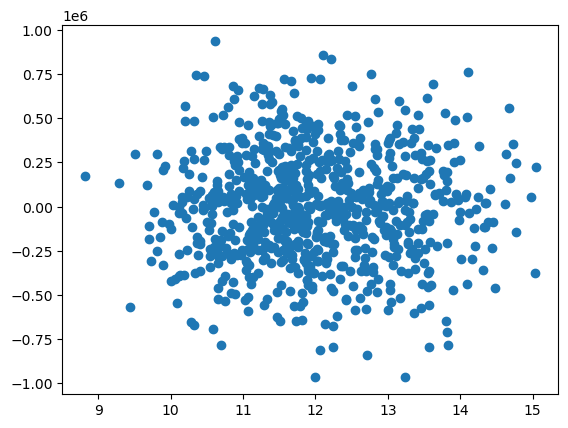

In [22]:
pred_Y, pred_std = model.predict(X, return_std=True)
plt.scatter(allY, prior_y)

In [ ]:
#provides metrics of the predictions wrt to the true column densities
mean_obs = metrics.mean_squared_error(Y, pred_Y) #(original CD, predicetd CD )
r2_obs = metrics.r2_score(Y, pred_Y) #(original, predicted)
print('MSE:', mean_obs)
print('r-squared:', r2_obs)


#splits into training and testing sets for plotting
test_obs  = np.delete(col_den, train_ind)
train_obs = np.delete(col_den, test_ind)

test_pred  = np.delete(pred_Y, train_ind)
train_pred = np.delete(pred_Y, test_ind)


# #========================================

plt.figure()
plt.scatter(train_obs, train_pred, color='blue', label='training')
plt.scatter(test_obs, test_pred, color='red', label='test')

plt.title('gaussian processing - without')
plt.xlabel(r'Observed $N{col}$ (log $cm^{-2})$')
plt.ylabel(r'Predicted $N_{col}$ (log $cm^{-2})$')
plt.annotate(r'$R^2$ ='            + str('%.3f'%(metrics.r2_score(col_den, pred_Y)))
             + '\nMSE = ' + str('%.3f'%(metrics.mean_squared_error(col_den, pred_Y))), (11.75, 17.5))
plt.legend(loc='best', fancybox=True, framealpha=0)
plt.ylim([9.5, 15])
plt.xlim([9.5, 15])

x = np.arange(9,23)
y = x
plt.plot(x, y, color='grey')

mean_test = metrics.mean_squared_error(test_obs, test_pred)
r2_test = metrics.r2_score(test_obs, test_pred)
print('\nmse of the test',mean_test)
print('\nr2 of test',r2_test)

mean_train= metrics.mean_squared_error(train_obs, train_pred)
r2_train = metrics.r2_score(train_obs, train_pred)
print('\nmse of the train',mean_train)
print('\nr2 of train',r2_train)

plt.show()

In [ ]:
joblib.dump(gp, 'name_ur_pickle.pkl')


MSE: 0.291606613933642
r-squared: 0.7079523839054631


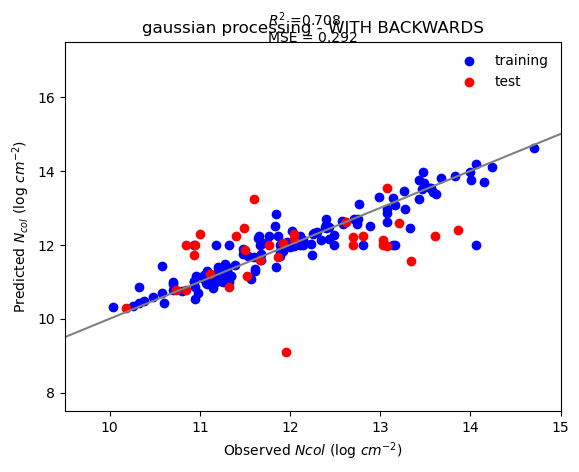

In [15]:
#provides metrics of the predictions wrt to the true column densities
mean_obs = metrics.mean_squared_error(Y, pred_Y) #(original CD, predicetd CD )
r2_obs = metrics.r2_score(Y, pred_Y) #(original, predicted)
print('MSE:', mean_obs)
print('r-squared:', r2_obs)


#splits into training and testing sets for plotting
test_obs  = np.delete(col_den, train_ind)
train_obs = np.delete(col_den, test_ind)

test_pred  = np.delete(pred_Y, train_ind)
train_pred = np.delete(pred_Y, test_ind)


# #========================================

plt.figure()
plt.scatter(train_obs, train_pred, color='blue', label='training')
plt.scatter(test_obs, test_pred, color='red', label='test')

plt.title('gaussian processing - WITH BACKWARDS')
plt.xlabel(r'Observed $N{col}$ (log $cm^{-2})$')
plt.ylabel(r'Predicted $N_{col}$ (log $cm^{-2})$')
plt.annotate(r'$R^2$ ='            + str('%.3f'%(metrics.r2_score(col_den, pred_Y)))
             + '\nMSE = ' + str('%.3f'%(metrics.mean_squared_error(col_den, pred_Y))), (11.75, 17.5))
plt.legend(loc='best', fancybox=True, framealpha=0)
plt.ylim([7.5, 17.5])
plt.xlim([9.5, 15])

x = np.arange(9,23)
y = x
plt.plot(x, y, color='grey')



plt.show()